
#**Overview**:
This project is about the analysis of tweets about coronavirus, with the goal of performing a Sentiment Analysis using roBERTa algorithms to predict the emotion of a tweet (Positive, Negative or Neutral). In particular, ROBERTA will be fine tuned using the given dataset in order to improve the model overall performance.
Before feeding the data to the algorithms, the tweets will be deeply cleaned to remove links, hashtags at the end of the sentences and punctuation to allow the algorithms to better understand the text and improve the prediction performance.

In [43]:
import pandas as pd
import numpy as np

import re
import string
import nltk
from nltk.corpus import stopwords, wordnet
from nltk.tokenize import TweetTokenizer
from nltk.stem import WordNetLemmatizer
from nltk import pos_tag
from tqdm.notebook import tqdm
from collections import Counter
import torch
from wordcloud import WordCloud, ImageColorGenerator
from PIL import Image
import imageio



from transformers import RobertaTokenizer, RobertaForSequenceClassification
from transformers import pipeline
from scipy.special import softmax

import seaborn as sns
import plotly.express as px
import plotly.figure_factory as ff
from plotly import graph_objs as go
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings('ignore')


# **Loading Data**

In [44]:
tweets = pd.read_csv('apple_vision_pro_tweets.csv')
tweets.head()

,Tweet
0,"Got the Apple Vision Pro, there is no better e..."
1,Apple Vision Pro was def a crazy experience
2,About to experience the Apple Vision Pro
3,1/5)Thoughts on the \n@Apple\n Vision Pro: I w...
4,Happy Headlines: Ready to dive into the futur...


In [45]:
tweets.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1013 entries, 0 to 1012
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Tweet   1013 non-null   object
dtypes: object(1)
memory usage: 8.0+ KB


# **Data Preprocessing**

In [46]:
nltk.download('averaged_perceptron_tagger')
nltk.download('wordnet')
nltk.download('stopwords')

[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [47]:
def get_wordnet_pos(treebank_tag):
    """
    Converts treebank POS tags to WordNet POS tags.
    """
    if treebank_tag.startswith('J'):
        return wordnet.ADJ
    elif treebank_tag.startswith('V'):
        return wordnet.VERB
    elif treebank_tag.startswith('N'):
        return wordnet.NOUN
    elif treebank_tag.startswith('R'):
        return wordnet.ADV
    else:
        return wordnet.NOUN  # Default to NOUN if no match

def clean_tweet(tweet):
    """
    Clean and preprocess the tweets.
    """
    tweet = re.sub(r'https?://\S+|www\.\S+', '', tweet)
    tweet = re.sub(r'@\w+|\#\w+', '', tweet)
    tweet = tweet.translate(str.maketrans('', '', string.punctuation))
    tweet = re.sub(r'\d+', '', tweet)
    # Remove non-ASCII characters
    tweet = tweet.encode('ascii', 'ignore').decode('ascii')
    tweet = tweet.lower()
    # Tokenize
    tokenizer = TweetTokenizer(preserve_case=False, reduce_len=True, strip_handles=True)
    tokens = tokenizer.tokenize(tweet)
    stop_words = set(stopwords.words('english'))
    tokens = [word for word in tokens if word not in stop_words]
    tokens = [word for word in tokens if word.strip() != '']

    # POS Tagging and Lemmatization
    lemmatizer = WordNetLemmatizer()
    tagged_tokens = pos_tag(tokens)
    lemmatized_tokens = []
    for word, tag in tagged_tokens:
        wntag = get_wordnet_pos(tag)
        lemmatized_tokens.append(lemmatizer.lemmatize(word, pos=wntag))

    # Join the tokens back into a string
    clean_tweet = ' '.join(lemmatized_tokens)

    return clean_tweet


In [48]:
tweets['Tweet'] = tweets['Tweet'].apply(clean_tweet)

In [49]:
tweets.head()

,Tweet
0,get apple vision pro good experience want watc...
1,apple vision pro def crazy experience
2,experience apple vision pro
3,thought vision pro walk demo yesterday know wa...
4,happy headline ready dive future apple vision ...


#**roBerta Pre-trained Model**

In [50]:
# load the tokenizer and model
tokenizer = RobertaTokenizer.from_pretrained('cardiffnlp/twitter-roberta-base-sentiment-latest')
model = RobertaForSequenceClassification.from_pretrained('cardiffnlp/twitter-roberta-base-sentiment-latest')

nlp = pipeline('sentiment-analysis', model=model , tokenizer=tokenizer)

Some weights of the model checkpoint at cardiffnlp/twitter-roberta-base-sentiment-latest were not used when initializing RobertaForSequenceClassification: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [51]:
def get_sentiment_score(text):
    result = nlp(text)[0]
    return pd.Series([result['label'], result['score']])

# Apply the function to the 'Tweet' column
tweets[['sentiment', 'score']] = tweets['Tweet'].apply(lambda x: get_sentiment_score(x))

In [52]:
tweets.head(30)

,Tweet,sentiment,score
0,get apple vision pro good experience want watc...,positive,0.956460
1,apple vision pro def crazy experience,positive,0.790630
2,experience apple vision pro,neutral,0.645760
3,thought vision pro walk demo yesterday know wa...,negative,0.497139
4,happy headline ready dive future apple vision ...,positive,0.966174
5,last night get try apple vision pro holy cowww...,positive,0.956324
6,secret sauce apple vision pro demo culture use...,negative,0.499715
7,say apple vision pro change concert view exper...,positive,0.544107
8,use apple vision pro first time thats cool exp...,positive,0.974049
9,try apple vision pro apple store yesterday her...,positive,0.919847


# **Analyze Sentiment Distribution**

In [53]:
sentiments = tweets.groupby('sentiment').count()['Tweet'].reset_index().sort_values(by='Tweet', ascending=False)
sentiments.style.background_gradient(cmap='Blues')

,sentiment,Tweet
2,positive,448
1,neutral,386
0,negative,179


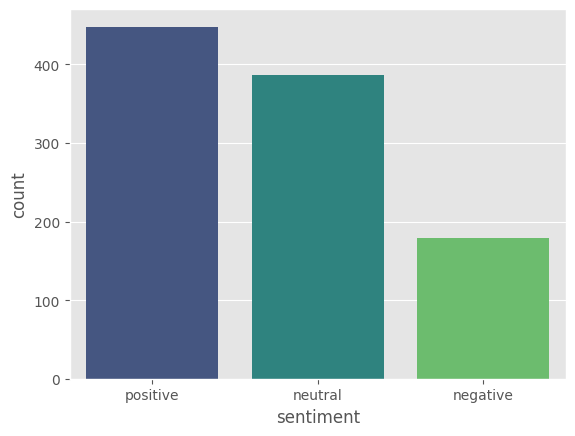

In [54]:
sns.countplot(x= tweets['sentiment'], palette='viridis')
plt.show()

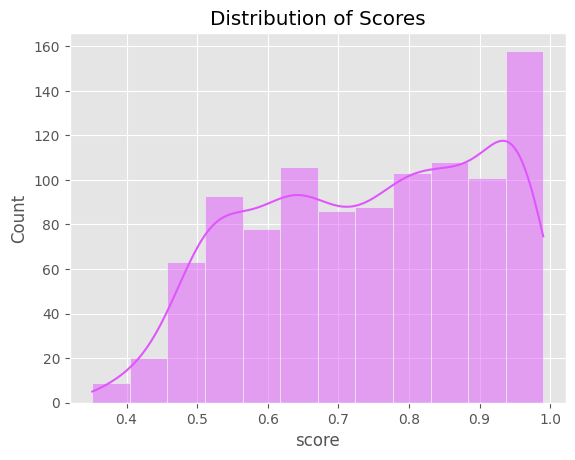

In [55]:
sns.histplot(tweets['score'], color='#e056fd', kde=True)
plt.title('Distribution of Scores')
plt.show()

In [56]:
fig = go.Figure(go.Funnelarea(
    text = sentiments.sentiment,
    values = sentiments.Tweet,
    title = {"position": "top center", "text": "Funnel-Chart of Sentiment Distribution"}
    ))
fig.show()

In [57]:
# word frequency
tweets['word_count'] = tweets['Tweet'].apply(lambda x: str(x).split())
top = Counter([item for sublist in tweets['word_count'] for item in sublist])
temp = pd.DataFrame(top.most_common(10))
temp.columns = ['Common_words', 'count']
temp.style.background_gradient(cmap='Blues')

,Common_words,count
0,apple,1157
1,vision,1099
2,pro,1096
3,review,587
4,experience,354
5,like,163
6,get,148
7,watch,141
8,see,141
9,use,139


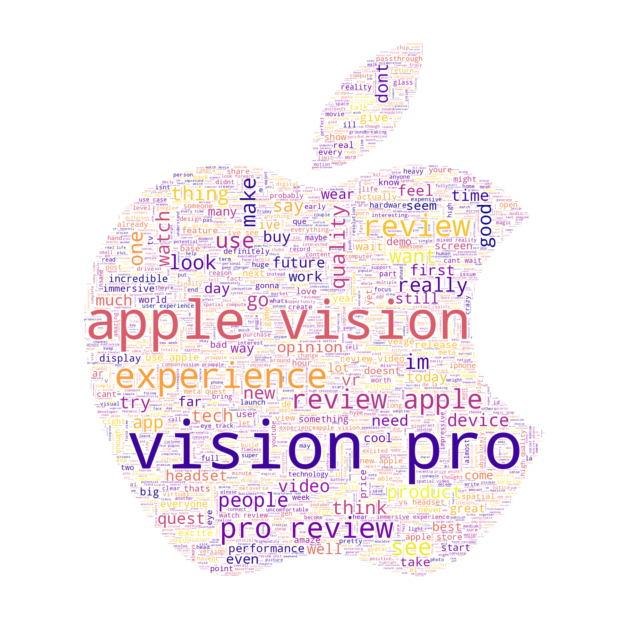

In [59]:
mask = imageio.imread('apple-logo-6.png')

text = ''.join(tweets['Tweet'])

wc = WordCloud(mask=mask, background_color='white', colormap='plasma', max_font_size=700, max_words=3000).generate(text)
plt.figure(figsize=(8,8))
plt.imshow(wc, interpolation='bilinear')
plt.axis('off')
plt.show()